In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
from scipy.stats import pearsonr, spearmanr
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.preprocessing import MinMaxScaler

def analyze_technical_correlations(ticker):
    # Step 1: Download stock data
    print(f"📥 Downloading data for {ticker}...")
    end_date = datetime.today()
    start_date = end_date - relativedelta(years=10)

    df = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust=True)
    if df.empty:
        print(f"❌ No data retrieved for {ticker}.")
        return

    df.reset_index(inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Step 2: Add all TA-lib indicators
    print("🧠 Computing all technical indicators...")
    df = dropna(df)
    df = add_all_ta_features(df,
                             open="Open", high="High", low="Low",
                             close="Close", volume="Volume",
                             fillna=True)

    df.reset_index(inplace=True)
    
    # Step 3: Normalize data
    print("📊 Normalizing numeric features...")
    df['Returns'] = df['Close'].pct_change()
    df['Lagged_Returns'] = df['Returns'].shift(1)
    df.dropna(inplace=True)

    scaler = MinMaxScaler()
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Step 4: Select indicator columns (exclude target variables)
    exclude_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Lagged_Returns']
    indicator_cols = [col for col in df.columns if col not in exclude_cols]

    # Step 5: Correlation Analysis
    print("🔍 Calculating correlations...")
    pearson_results = {'Price': {}, 'Returns': {}, 'Lagged_Returns': {}}
    spearman_results = {'Price': {}, 'Returns': {}, 'Lagged_Returns': {}}

    def calculate_correlations(data, x_col, y_col, lag=0):
        x = data[x_col].shift(lag) if lag > 0 else data[x_col]
        y = data[y_col]
        valid_data = pd.concat([x, y], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
        if len(valid_data) < 3:
            return np.nan, np.nan
        try:
            p_corr, _ = pearsonr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
            s_corr, _ = spearmanr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
            return p_corr, s_corr
        except:
            return np.nan, np.nan

    for col in indicator_cols:
        for label, y_col, lag in [('Price', 'Close', 0), ('Returns', 'Returns', 0), ('Lagged_Returns', 'Returns', 1)]:
            p_corr, s_corr = calculate_correlations(df, col, y_col, lag)
            pearson_results[label][col] = p_corr
            spearman_results[label][col] = s_corr

    pearson_df = pd.DataFrame(pearson_results)
    spearman_df = pd.DataFrame(spearman_results)

    # Step 6: Save correlation data
    pearson_df.to_csv(f"{ticker}_pearson_correlations.csv")
    spearman_df.to_csv(f"{ticker}_spearman_correlations.csv")

    # Step 7: Visualize with heatmaps
    print("📈 Creating heatmaps...")
    plt.figure(figsize=(14, 10))
    sns.heatmap(pearson_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f"{ticker} - Pearson Correlation Heatmap")
    plt.tight_layout()
    plt.savefig(f"{ticker}_pearson_heatmap.png")
    plt.show()

    plt.figure(figsize=(14, 10))
    sns.heatmap(spearman_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f"{ticker} - Spearman Correlation Heatmap")
    plt.tight_layout()
    plt.savefig(f"{ticker}_spearman_heatmap.png")
    plt.show()

    # Step 8: Show strong correlations
    print("\n📌 Significant Pearson Correlations (|corr| > 0.3):")
    print(pearson_df[(pearson_df['Price'].abs() > 0.7)])

    print("\n📌 Significant Spearman Correlations (|corr| > 0.3):")
    print(spearman_df[(spearman_df['Returns'].abs() > 0.7)])

    print(f"\n✅ All outputs saved for {ticker}.")


📥 Downloading data for TCS.NS...


[*********************100%***********************]  1 of 1 completed


🧠 Computing all technical indicators...
📊 Normalizing numeric features...
🔍 Calculating correlations...
📈 Creating heatmaps...


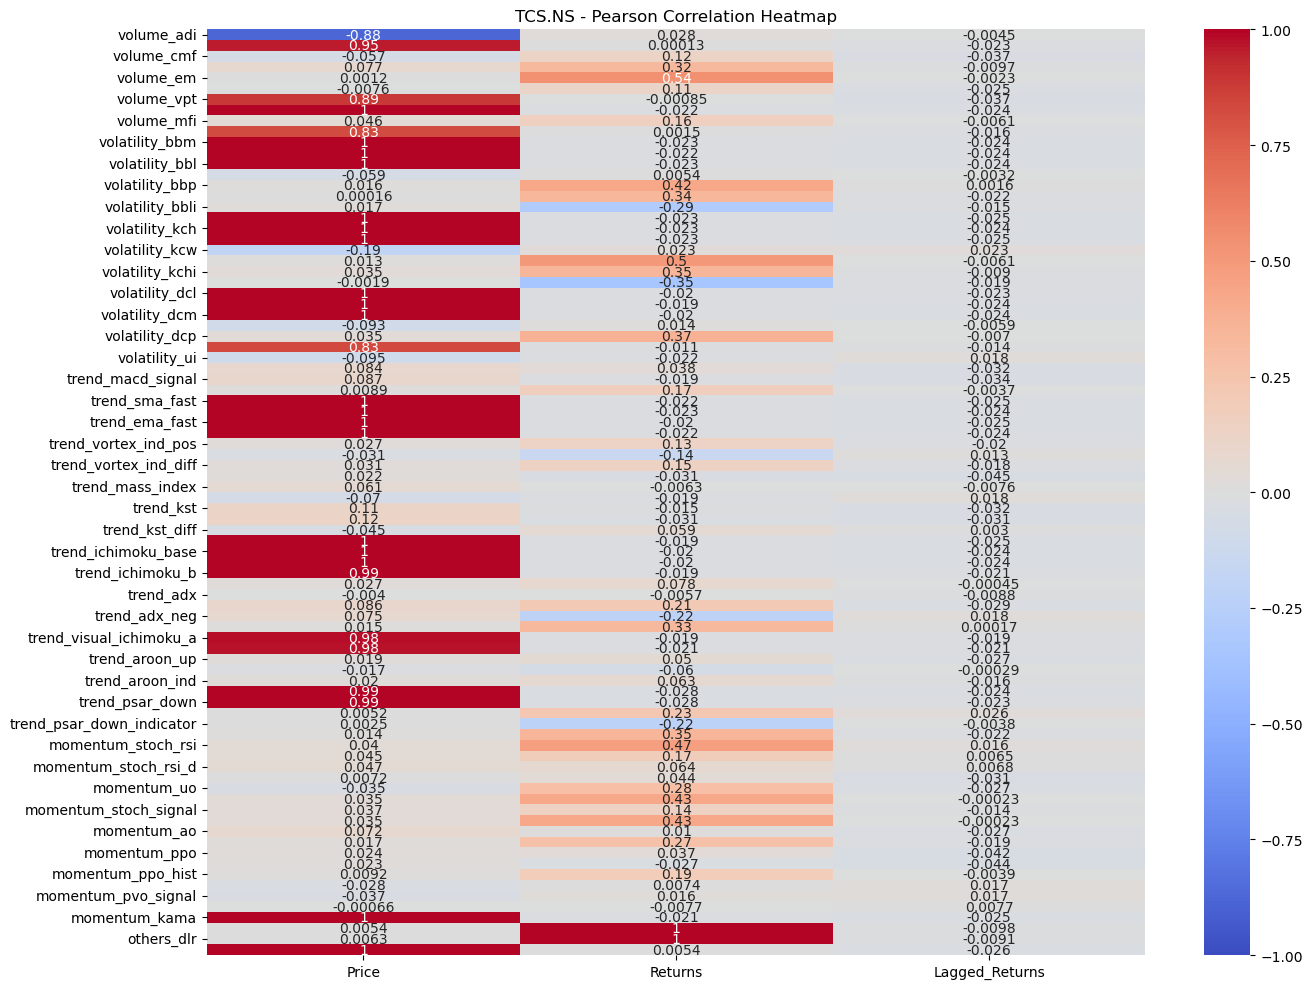

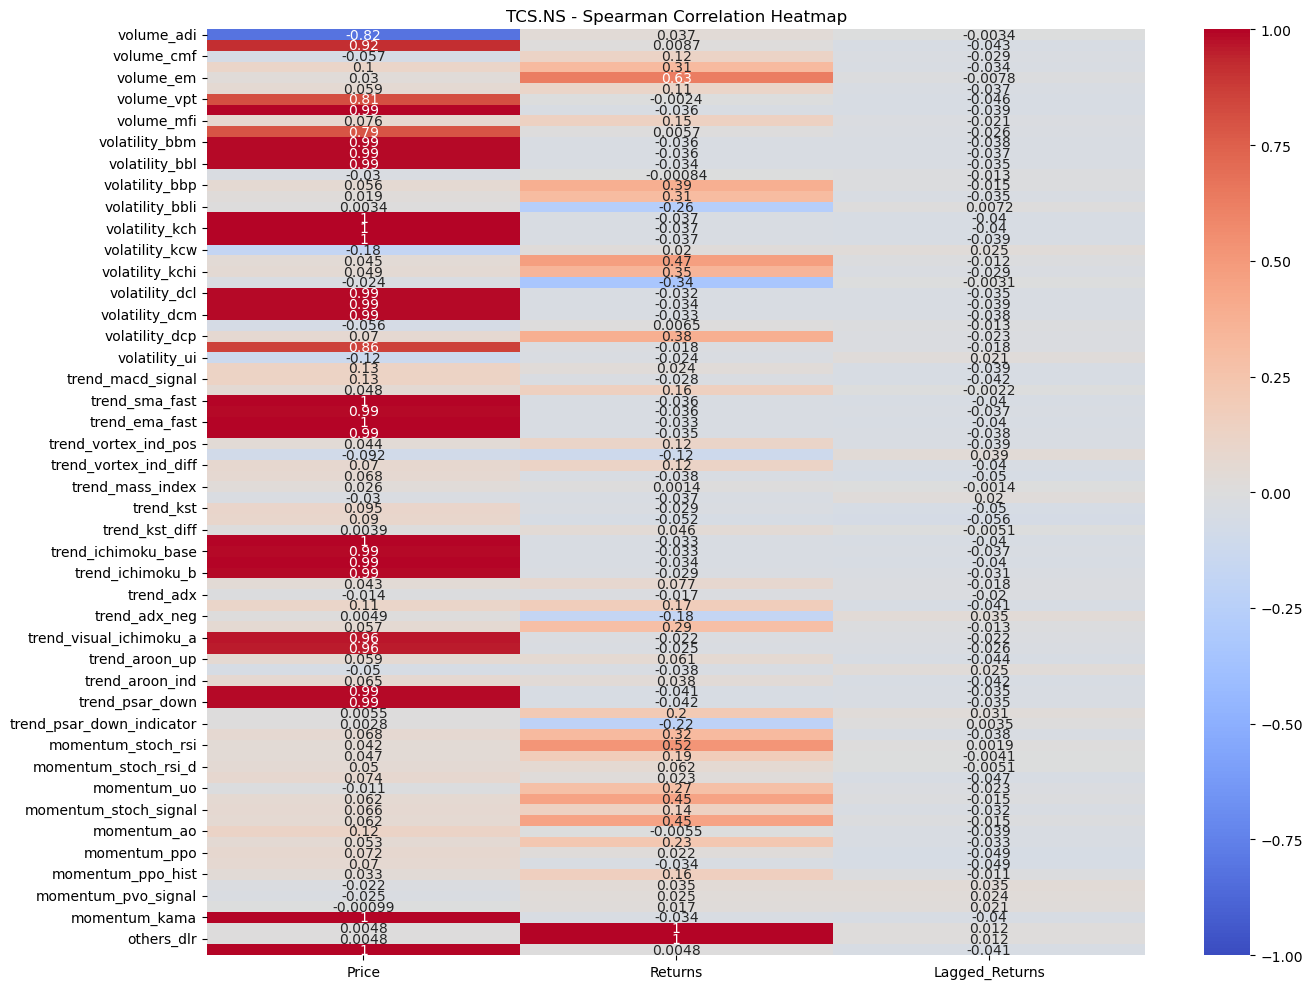


📌 Significant Pearson Correlations (|corr| > 0.3):
                            Price   Returns  Lagged_Returns
volume_adi              -0.876314  0.027952       -0.004469
volume_obv               0.954894  0.000128       -0.023085
volume_vpt               0.890389 -0.000854       -0.036625
volume_vwap              0.997825 -0.021844       -0.024294
volume_nvi               0.827073  0.001513       -0.016305
volatility_bbm           0.996613 -0.022776       -0.023981
volatility_bbh           0.995712 -0.022444       -0.023877
volatility_bbl           0.995151 -0.023081       -0.024035
volatility_kcc           0.998240 -0.022746       -0.024711
volatility_kch           0.998152 -0.022503       -0.024467
volatility_kcl           0.998177 -0.022994       -0.024959
volatility_dcl           0.995755 -0.020130       -0.023359
volatility_dch           0.996245 -0.019306       -0.023757
volatility_dcm           0.996944 -0.019718       -0.023589
volatility_atr           0.833936 -0.010935     

[*********************100%***********************]  1 of 1 completed


🧠 Computing all technical indicators...
📊 Normalizing numeric features...
🔍 Calculating correlations...
📈 Creating heatmaps...


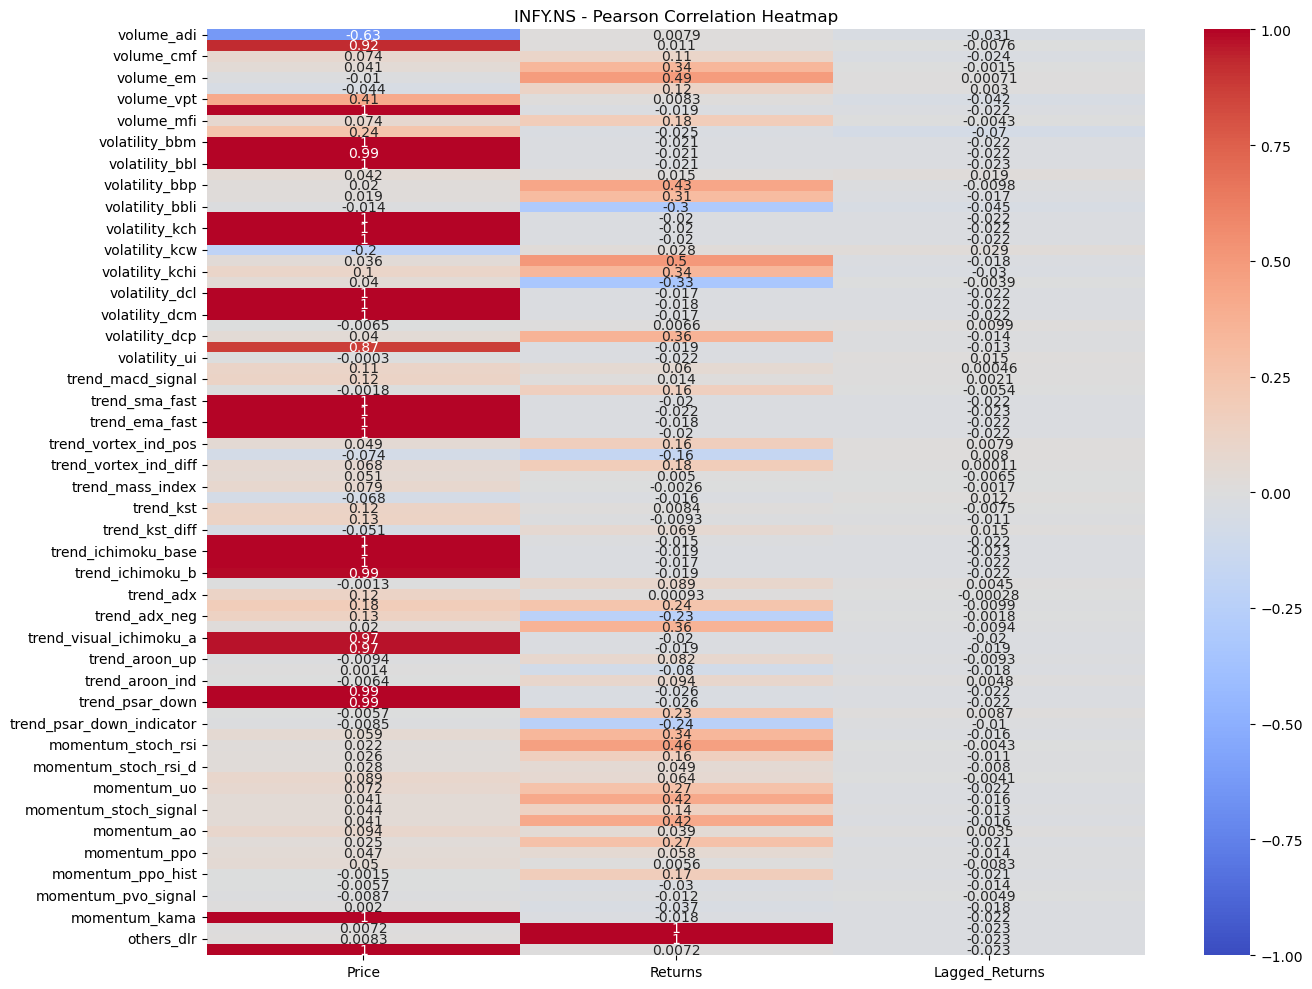

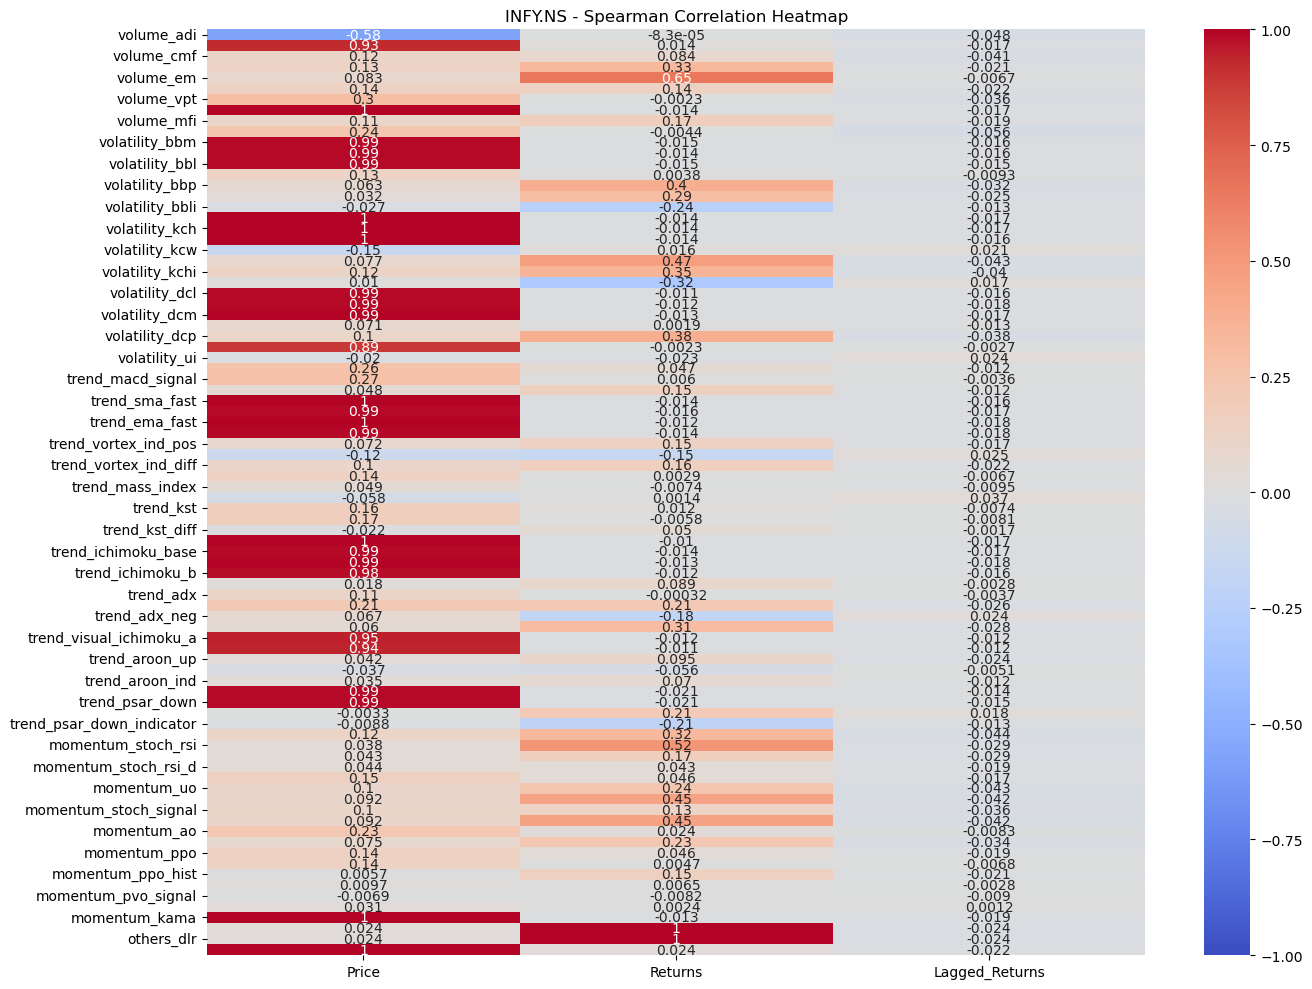


📌 Significant Pearson Correlations (|corr| > 0.3):
                            Price   Returns  Lagged_Returns
volume_obv               0.922959  0.011189       -0.007599
volume_vwap              0.997895 -0.018583       -0.022034
volatility_bbm           0.996398 -0.020871       -0.022268
volatility_bbh           0.994542 -0.020732       -0.021946
volatility_bbl           0.995354 -0.020960       -0.022555
volatility_kcc           0.998255 -0.019850       -0.022024
volatility_kch           0.998159 -0.019684       -0.021848
volatility_kcl           0.998240 -0.020020       -0.022204
volatility_dcl           0.996041 -0.016686       -0.022204
volatility_dch           0.995513 -0.017834       -0.022325
volatility_dcm           0.996798 -0.017308       -0.022291
volatility_atr           0.873548 -0.019248       -0.013244
trend_sma_fast           0.997965 -0.019748       -0.021967
trend_sma_slow           0.995072 -0.021897       -0.022980
trend_ema_fast           0.998515 -0.017950     

[*********************100%***********************]  1 of 1 completed


🧠 Computing all technical indicators...
📊 Normalizing numeric features...
🔍 Calculating correlations...
📈 Creating heatmaps...


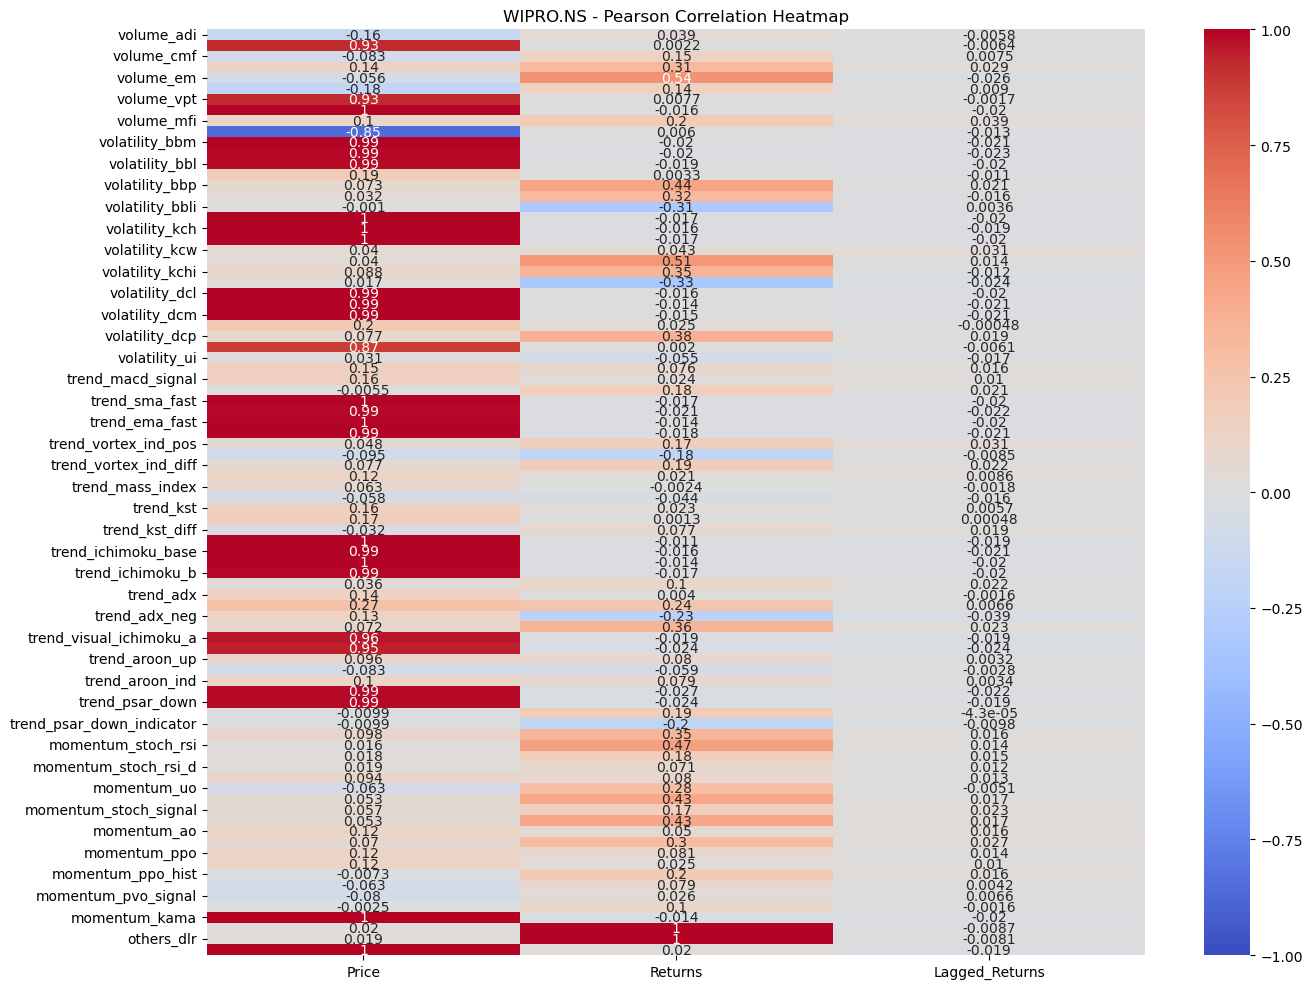

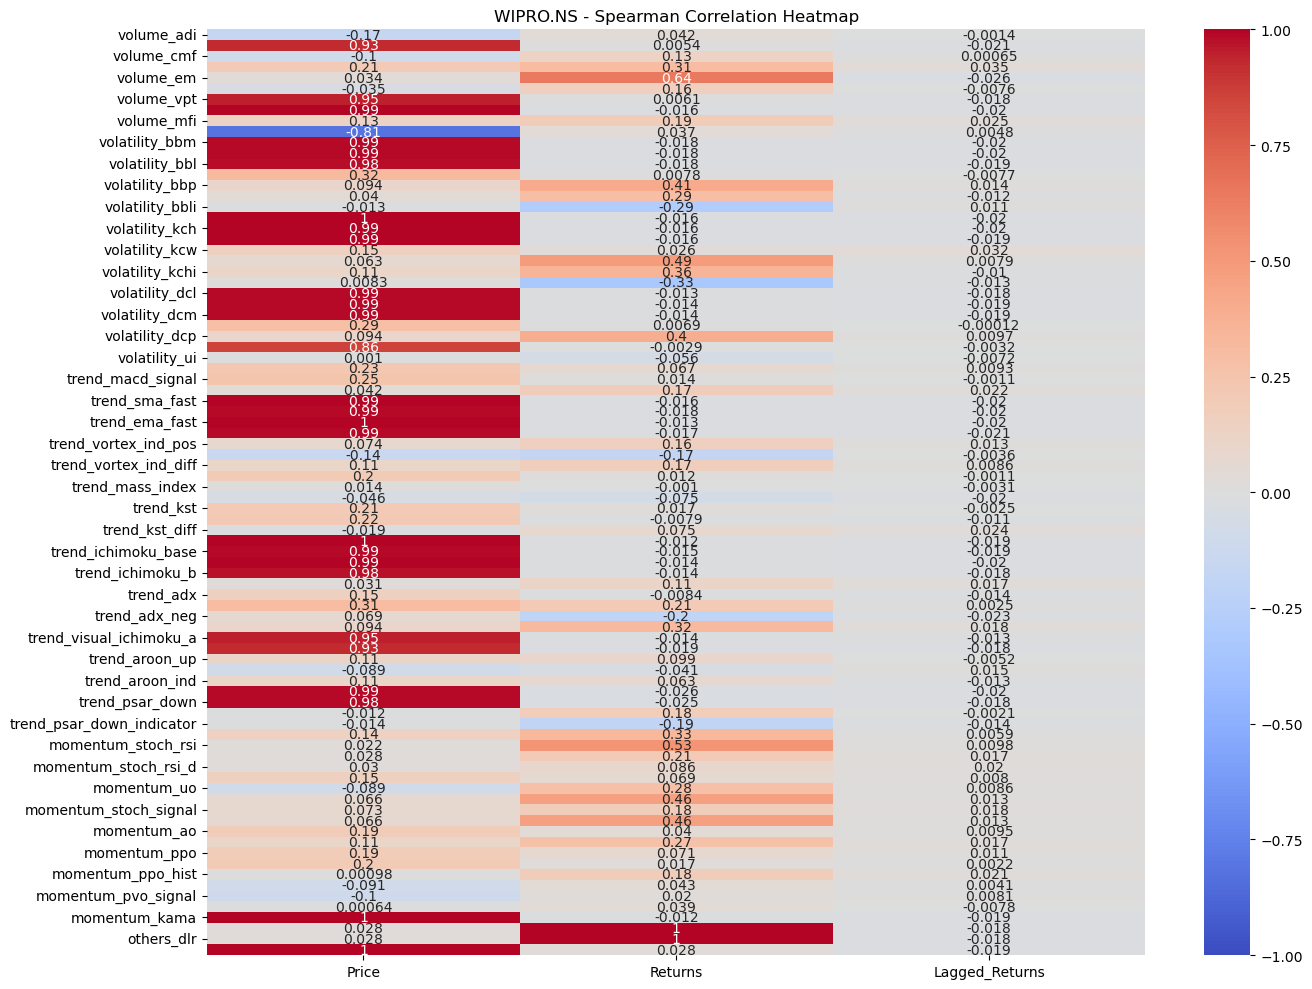


📌 Significant Pearson Correlations (|corr| > 0.3):
                            Price   Returns  Lagged_Returns
volume_obv               0.926038  0.002182       -0.006418
volume_vpt               0.929600  0.007653       -0.001652
volume_vwap              0.996457 -0.015913       -0.020438
volume_nvi              -0.851714  0.005982       -0.013307
volatility_bbm           0.993745 -0.019745       -0.021386
volatility_bbh           0.990937 -0.020382       -0.022740
volatility_bbl           0.991394 -0.018904       -0.019711
volatility_kcc           0.997179 -0.016804       -0.019751
volatility_kch           0.997137 -0.016243       -0.019351
volatility_kcl           0.996971 -0.017388       -0.020165
volatility_dcl           0.992911 -0.015525       -0.020011
volatility_dch           0.992257 -0.014426       -0.021016
volatility_dcm           0.994344 -0.014963       -0.020586
volatility_atr           0.869575  0.001950       -0.006072
trend_sma_fast           0.996679 -0.017129     

In [6]:
analyze_technical_correlations("TCS.NS")
analyze_technical_correlations("INFY.NS")
analyze_technical_correlations("WIPRO.NS")
